# Grow-Shrink Algorithm for Tabular Markov Blanket Discovery

The Grow-Shrink algorithm can be used for discovering the minimal Markov blanket (MB) of a target variable in tabular
data. A MB is a minimal conditioning set making the target variable independent of all other variables; under the
assumption of faithfulness, which we make here, the MB is unique and corresponds to the set of parents, children and
co-parents of the target variable. The MB can be used for feature selection.

The Grow-Shrink algorithm operates in two phases, called growth and shrink. The growth phase first adds to the MB
estimation variables unconditionally dependent on the target variable, then conditions on those variables and adds the
conditionally dependent variables to the estimation. Assuming perfect conditional independence testing, this yields a
superset of the actual MB. The shrink phase then removes from the estimated MB variables independent from the target
variable conditional on all other variables in the MB estimation. The algorithm does not partition the estimated MB into
parents/children/co-parents.

The assumptions we make for the growth-shrink algorithm are:
1. Causal Markov condition, which implies that two variables that are d-separated in a causal graph are probabilistically independent
2. faithfulness, i.e., no conditional independence can hold unless the Causal Markov condition is met
3. no hidden confounders
4. no cycles in the causal graph.

In [1]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline     
import pickle as pkl
import time

In [2]:

from causalai.models.tabular.grow_shrink import GrowShrink
from causalai.models.common.CI_tests.partial_correlation import PartialCorrelation
from causalai.models.common.CI_tests.discrete_ci_tests import DiscreteCI_tests
from causalai.models.common.CI_tests.kci import KCI


# also importing data object, and prior knowledge object, and the graph plotting function
from causalai.data.data_generator import DataGenerator, GenerateRandomTabularSEM
from causalai.data.tabular import TabularData
from causalai.data.transforms.time_series import StandardizeTransform
from causalai.models.common.prior_knowledge import PriorKnowledge
from causalai.misc.misc import plot_graph, get_precision_recall, get_precision_recall_skeleton, make_symmetric,\
                               _get_precision_recall_single

# Helper functions to compute ground truth

from causalai.tests.data.transforms.networkx_helper_functions import causalai2networkx, compute_markov_blanket

## Load and Visualize Data

Load the dataset and visualize the ground truth causal graph. For the purpose of this example, we will use a synthetic dataset available in our repository.

In [3]:
fn = lambda x:x
coef = 0.1
sem = {
        'a': [], 
        'b': [('a', coef, fn), ('f', coef, fn)], 
        'c': [('b', coef, fn), ('f', coef, fn)],
        'd': [('b', coef, fn), ('g', coef, fn)],
        'e': [('f', coef, fn)], 
        'f': [],
        'g': [],
        }
T = 5000

# var_names = [str(i) for i in range(5)]
# sem = GenerateRandomTabularSEM(var_names=var_names, max_num_parents=2, seed=1)
data_array, var_names, graph_gt = DataGenerator(sem, T=T, seed=0, discrete=False)

graph_gt

{'a': [],
 'b': ['a', 'f'],
 'c': ['b', 'f'],
 'd': ['b', 'g'],
 'e': ['f'],
 'f': [],
 'g': []}

Now we perform the following operations:
1. Standardize the data arrays
2. Create the data object

In [4]:


# 1.
StandardizeTransform_ = StandardizeTransform()
StandardizeTransform_.fit(data_array)

data_trans = StandardizeTransform_.transform(data_array)

# 2.
data_obj = TabularData(data_trans, var_names=var_names)



We visualize the data and graph below:

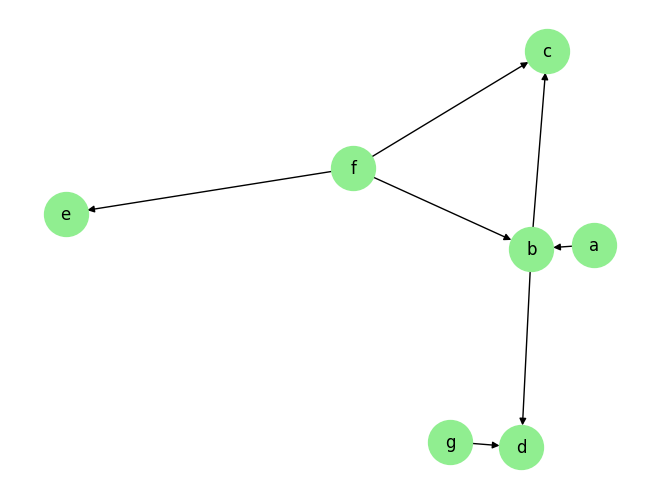

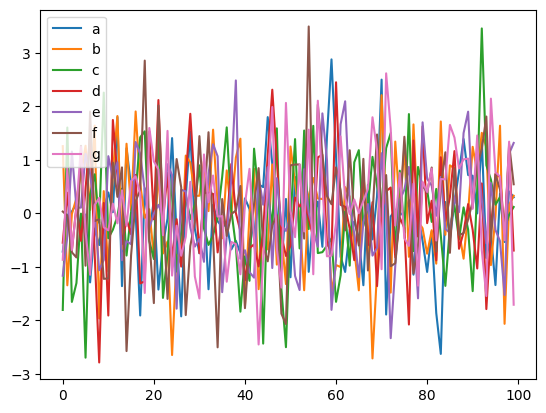

In [5]:


plot_graph(graph_gt, node_size=1000)



for i, n in enumerate(var_names):
    plt.plot(data_trans[-100:,i], label=n)
plt.legend()
plt.legend()
plt.show()

## Markov Blanket (MB) Discovery

Enable/Disable Multi-Processing:

When we instantiate our MB discovery model, we need to decide if we want to use multi-processing. Multi-processing typically provides a significant speed-up for the PC algorithm. In order to use multi-processing in our causal discovery library, we pass the argument use_multiprocessing=True to the model constructor. It's default value is False.

### MB Discovery for continuous data

In [6]:
prior_knowledge = None #  PriorKnowledge(forbidden_links={'a': ['b']})

pvalue_thres = 0.01
CI_test = PartialCorrelation() 
# CI_test = KCI(chunk_size=100) # use if the causal relationship is expected to be non-linear
gs = GrowShrink(
        data=data_obj,
        prior_knowledge=prior_knowledge,
        CI_test=CI_test,
        use_multiprocessing=False,
        update_shrink=False
        )

target_var = 'b'


In [7]:
tic = time.time()


result = gs.run(target_var=target_var, pvalue_thres=pvalue_thres)

toc = time.time()
    
print(f'Time taken: {toc-tic:.2f}s\n')

print(f" target var {target_var}\'s estimated MB is: {result['markov_blanket']}")

ground_truth_mb = compute_markov_blanket(causalai2networkx(graph_gt), target_var)

print(f" target var {target_var}\'s true MB is: {ground_truth_mb}")

precision, recall, f1_score = _get_precision_recall_single(result['markov_blanket'], ground_truth_mb)

print(f'Precision {precision:.2f}, Recall: {recall:.2f}, F1 score: {f1_score:.2f}')

Time taken: 0.03s

 target var b's estimated MB is: ['f', 'd', 'a', 'c']
 target var b's true MB is: {'f', 'd', 'g', 'a', 'c'}
Precision 1.00, Recall: 0.80, F1 score: 0.89


The output _result_ is a dictionary contains the estimated MB under result['markov blanket']. Under result['value_dict'] and result['pvalue_dict'], it contains a dictionary of link strengths between target_var and each each other variable, and a dictionary of the p-value of said strengths respectively. Under result['full_record_values'] and result['full_record_pvalues'], it contains the full history of raw/pvalue of CI tests performed in their order of performance ('value_dict' and 'pvalue_dict' will contain the result of the last such CI test for each variable).

### MB Discovery for Discrete Data

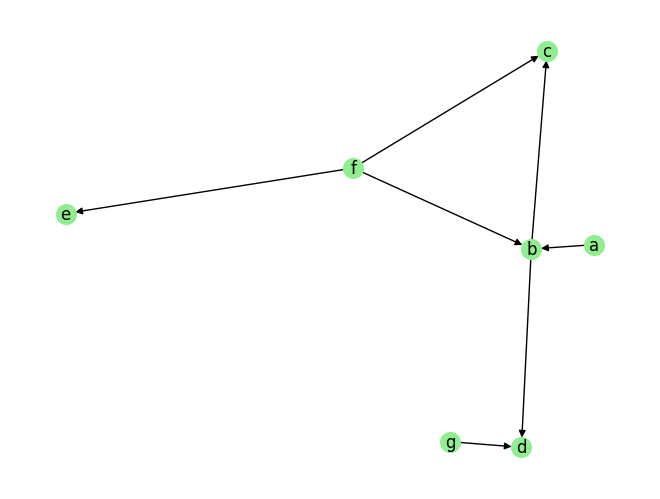

{'a': [],
 'b': ['a', 'f'],
 'c': ['b', 'f'],
 'd': ['b', 'g'],
 'e': ['f'],
 'f': [],
 'g': []}

In [8]:
fn = lambda x:x
coef = 0.1
sem = {
        'a': [], 
        'b': [('a', coef, fn), ('f', coef, fn)], 
        'c': [('b', coef, fn), ('f', coef, fn)],
        'd': [('b', coef, fn), ('g', coef, fn)],
        'e': [('f', coef, fn)], 
        'f': [],
        'g': [],
        }
T = 5000
data_array, var_names, graph_gt = DataGenerator(sem, T=T, seed=0, discrete=True)

plot_graph(graph_gt, node_size=200)
graph_gt

In [9]:

data_obj = TabularData(data_array, var_names=var_names)


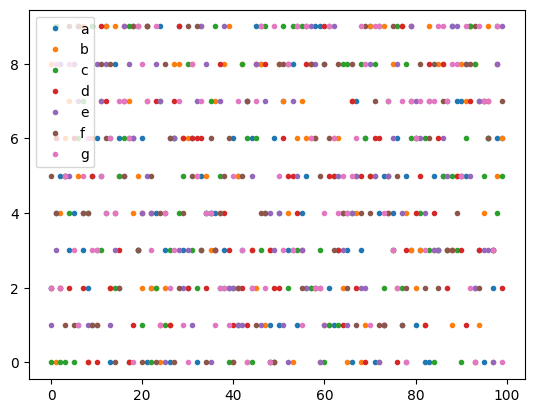

In [10]:

for i, n in enumerate(var_names):
    plt.plot(data_array[-100:,i], '.', label=n)
plt.legend()
plt.legend()
plt.show()

In [11]:


prior_knowledge =None# PriorKnowledge(forbidden_links={'c': ['e']}) # g cannot be a parent of c

pvalue_thres = 0.05
CI_test = DiscreteCI_tests(method="pearson")
gs = GrowShrink(
        data=data_obj,
        prior_knowledge=prior_knowledge,
        CI_test=CI_test,
        use_multiprocessing=False,
        update_shrink=False
        )

target_var = 'c'

tic = time.time()

result = gs.run(target_var=target_var, pvalue_thres=pvalue_thres)

toc = time.time()
    
print(f'Time taken: {toc-tic:.2f}s\n')



Time taken: 0.94s



In [12]:
print(f" target var {target_var}\'s estimated MB is: {result['markov_blanket']}")

ground_truth_mb = compute_markov_blanket(causalai2networkx(graph_gt), target_var)

print(f" target var {target_var}\'s true MB is: {ground_truth_mb}")

precision, recall, f1_score = _get_precision_recall_single(result['markov_blanket'], ground_truth_mb)

print(f'Precision {precision:.2f}, Recall: {recall:.2f}, F1 score: {f1_score:.2f}')

 target var c's estimated MB is: ['f', 'b', 'e']
 target var c's true MB is: {'f', 'b'}
Precision 0.67, Recall: 1.00, F1 score: 0.80


### Prior Knowledge Usage

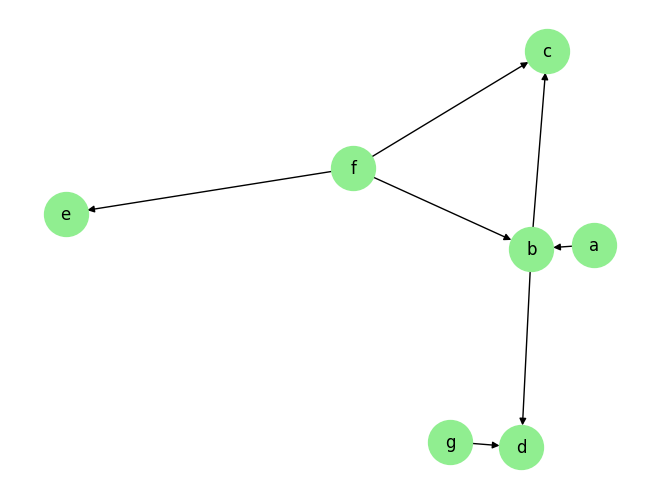

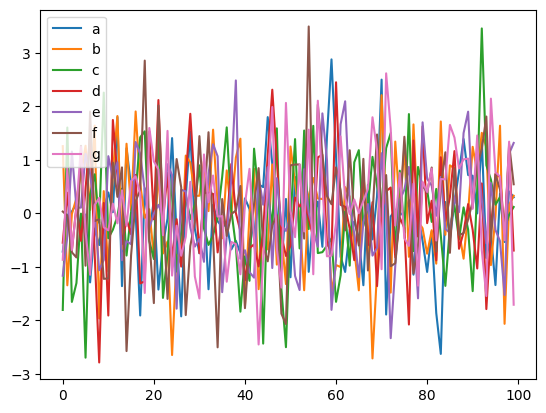

In [13]:
# recreating continuous data from earlier

fn = lambda x:x
coef = 0.1
sem = {
        'a': [],
        'b': [('a', coef, fn), ('f', coef, fn)],
        'c': [('b', coef, fn), ('f', coef, fn)],
        'd': [('b', coef, fn), ('g', coef, fn)],
        'e': [('f', coef, fn)],
        'f': [],
        'g': [],
        }
T = 5000

# var_names = [str(i) for i in range(5)]
# sem = GenerateRandomTabularSEM(var_names=var_names, max_num_parents=2, seed=1)
data_array, var_names, graph_gt = DataGenerator(sem, T=T, seed=0, discrete=False)

StandardizeTransform_ = StandardizeTransform()
StandardizeTransform_.fit(data_array)

data_trans = StandardizeTransform_.transform(data_array)

data_obj = TabularData(data_trans, var_names=var_names)

plot_graph(graph_gt, node_size=1000)

for i, n in enumerate(var_names):
    plt.plot(data_trans[-100:,i], label=n)
plt.legend()
plt.legend()
plt.show()

**Prior Knowledge**: specifying inclusion in MB. This can be done by specifying existing_co_parents or existing_links (or both). Note that without prior knowledge, the algorithm misses a in f's MB, but with prior knowledge that mistake is corrected.

In [14]:
### without Prior knowledge

prior_knowledge = None

pvalue_thres = 0.01

CI_test = PartialCorrelation()

gs = GrowShrink(
        data=data_obj,
        prior_knowledge=prior_knowledge,
        CI_test=CI_test,
        use_multiprocessing=False,
        update_shrink=False
        )

target_var = 'f'

tic = time.time()

result = gs.run(target_var=target_var, pvalue_thres=pvalue_thres)

toc = time.time()

print(f'Time taken without prior knowledge: {toc-tic:.2f}s\n')

print(f"target var {target_var}\'s estimated MB without prior knowledge is: {result['markov_blanket']}")

ground_truth_mb = compute_markov_blanket(causalai2networkx(graph_gt), target_var)

print(f"target var {target_var}\'s true MB is: {ground_truth_mb}")

precision, recall, f1_score = _get_precision_recall_single(result['markov_blanket'], ground_truth_mb)

print(f'Precision {precision:.2f}, Recall: {recall:.2f}, F1 score: {f1_score:.2f}\n')


### with Prior knowledge
prior_knowledge = PriorKnowledge(existing_co_parents={'f': ['a']})

gs = GrowShrink(
        data=data_obj,
        prior_knowledge=prior_knowledge,
        CI_test=CI_test,
        use_multiprocessing=False,
        update_shrink=False
        )

tic = time.time()

result = gs.run(target_var=target_var, pvalue_thres=pvalue_thres)

toc = time.time()

print(f'Time taken with prior knowledge: {toc-tic:.2f}s\n')

print(f"target var {target_var}\'s estimated MB with prior knowledge is: {result['markov_blanket']}")

precision, recall, f1_score = _get_precision_recall_single(result['markov_blanket'], ground_truth_mb)

print(f'Precision {precision:.2f}, Recall: {recall:.2f}, F1 score: {f1_score:.2f}')

Time taken without prior knowledge: 0.02s

target var f's estimated MB without prior knowledge is: ['b', 'c', 'e']
target var f's true MB is: {'b', 'a', 'c', 'e'}
Precision 1.00, Recall: 0.75, F1 score: 0.86

Time taken with prior knowledge: 0.02s

target var f's estimated MB with prior knowledge is: ['a', 'b', 'c', 'e']
Precision 1.00, Recall: 1.00, F1 score: 1.00


**Prior Knowledge**: specifying exclusion from MB. This can be done by specifying forbidden_co_parents and forbidden_links: note that PriorKnowledge needs to forbid a variable from being a *co-parent*, *and* from being a *parent*, *and* from being a *child* of the target variable to guarantee exclusion from MB (if any of these three are missing, the variable would be considered as a valid candidate for inclusion in the MB). 

Note that without prior knowledge, the algorithm includes c and d in a's MB, but with prior knowledge that mistake is corrected. The large pvalue_thres chosen is merely for demonstration purposes.

In [111]:
### without Prior knowledge
prior_knowledge = None

pvalue_thres = 0.2

CI_test = PartialCorrelation()

gs = GrowShrink(
        data=data_obj,
        prior_knowledge=prior_knowledge,
        CI_test=CI_test,
        use_multiprocessing=False,
        update_shrink=False
        )

target_var = 'a'

tic = time.time()

result = gs.run(target_var=target_var, pvalue_thres=pvalue_thres)

toc = time.time()

print(f'Time taken without prior knowledge: {toc-tic:.2f}s\n')

print(f"target var {target_var}\'s estimated MB without prior knowledge is: {result['markov_blanket']}")

ground_truth_mb = compute_markov_blanket(causalai2networkx(graph_gt), target_var)

print(f"target var {target_var}\'s true MB is: {ground_truth_mb}")

precision, recall, f1_score = _get_precision_recall_single(result['markov_blanket'], ground_truth_mb)

print(f'Precision {precision:.2f}, Recall: {recall:.2f}, F1 score: {f1_score:.2f}\n')

### with Prior knowledge
prior_knowledge = PriorKnowledge(forbidden_co_parents={'a': ['c','d']}, 
                                 forbidden_links={'a': ['c','d'], 'c': ['a'], 'd': ['a']})

gs = GrowShrink(
        data=data_obj,
        prior_knowledge=prior_knowledge,
        CI_test=CI_test,
        use_multiprocessing=False,
        update_shrink=False
        )

tic = time.time()

result = gs.run(target_var=target_var, pvalue_thres=pvalue_thres)

toc = time.time()

print(f'Time taken with prior knowledge: {toc-tic:.2f}s\n')

print(f"target var {target_var}\'s estimated MB with prior knowledge is: {result['markov_blanket']}")

precision, recall, f1_score = _get_precision_recall_single(result['markov_blanket'], ground_truth_mb)

print(f'Precision {precision:.2f}, Recall: {recall:.2f}, F1 score: {f1_score:.2f}')

Time taken without prior knowledge: 0.05s

target var a's estimated MB without prior knowledge is: ['c', 'b', 'd', 'f']
target var a's true MB is: {'b', 'f'}
Precision 0.50, Recall: 1.00, F1 score: 0.67

Time taken with prior knowledge: 0.02s

target var a's estimated MB with prior knowledge is: ['b', 'f']
Precision 1.00, Recall: 1.00, F1 score: 1.00


It should be noted that GrowShrink considers prior knowledge ex-ante rather than ex-post. In other words, the algorithm takes the prior knowledge into consideration in its decision making process, rather than just apply it to the predicted MB after the fact. Therefore, given an imperfect CI test, it is possible for correct prior knowledge to cause the algorithm to make mistakes it would not have made without the prior knowledge. Nevertheless, our recommendation is to include all correct prior knowledge as input.